In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns

/mnt/ShareDrive/Development/UzK/COINs-CNN-FLOW/Uvenv/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Flow Prediction Import

In [2]:
flow_predictions = pd.read_csv('../data/yt_analysis/results.csv')
flow_predictions['VID'] = flow_predictions.FILE.apply(lambda x: int(x.split('_')[0].split('/')[-1]))
flow_predictions['FRAME'] = flow_predictions.FILE.apply(lambda x: x.split('_')[-4])
flow_predictions['FLOW'] = flow_predictions.FILE.apply(lambda x: int(x.split('_')[-2]))
flow_predictions.drop(columns=['FILE'], inplace=True)
flow_predictions.head(5)

,PROB,VID,FRAME,FLOW
0,0.652541,11,7258,1
1,0.518073,13,574,0
2,0.592700,12,6192,0
3,0.474445,42,7136,0
4,0.345597,19,1075,0


In [3]:
fpr, tpr, _ = roc_curve(flow_predictions.FLOW.to_numpy(), flow_predictions.PROB.to_numpy())
roc_auc = auc(fpr, tpr)

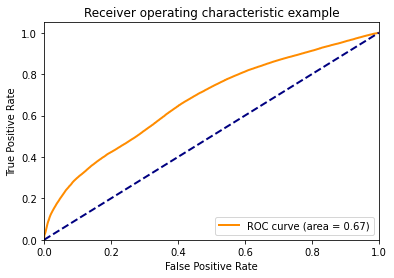

In [4]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

<AxesSubplot:xlabel='FLOW', ylabel='PROB'>

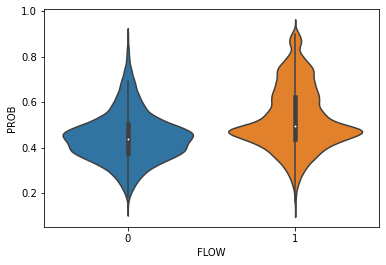

In [5]:
sns.violinplot(data=flow_predictions, x='FLOW', y='PROB')

In [6]:
flow_predictions.loc[flow_predictions['PROB'] >= 0.5, 'PRED'] = int(1)
flow_predictions.loc[flow_predictions['PROB'] < 0.5, 'PRED'] = int(0)

flow_predictions['ACC'] = flow_predictions['FLOW'] == flow_predictions['PRED'].astype('int')
sum(flow_predictions['ACC'])/len(flow_predictions)

0.6821462045081055

# Emotion Data Import

In [7]:
emo_pred = pd.read_csv('../data/yt_analysis/FER_results.csv')
emo_pred['VID'] = emo_pred.FILE.apply(lambda x: int(x.split('_')[0].split('/')[-1]))
emo_pred['FRAME'] = emo_pred.FILE.apply(lambda x: x.split('_')[-4])
emo_pred['FLOW'] = emo_pred.FILE.apply(lambda x: int(x.split('_')[-2]))
emo_pred.drop(columns=['FILE','FLOW'], inplace=True)
emo_pred.head(5)

,EMO,VID,FRAME
0,Anger,50,5843
1,Fear,55,7507
2,Happinness,12,4856
3,Happinness,30,9242
4,Neutral,7,272


In [8]:
full_pred = flow_predictions.merge(emo_pred, on=['VID','FRAME'])
full_pred.head(5)

,PROB,VID,FRAME,FLOW,PRED,ACC,EMO
0,0.652541,11,7258,1,1.0,True,Happinness
1,0.518073,13,574,0,1.0,False,Happinness
2,0.592700,12,6192,0,1.0,False,Happinness
3,0.474445,42,7136,0,0.0,True,Happinness
4,0.345597,19,1075,0,0.0,True,Anger


<AxesSubplot:xlabel='EMO', ylabel='PROB'>

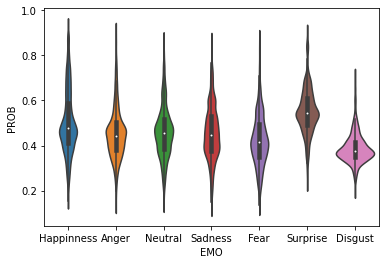

In [9]:
sns.violinplot(data=full_pred, x='EMO', y='PROB')

In [10]:
dummies = pd.get_dummies(full_pred['EMO'], drop_first=False)
final_pred = pd.concat([full_pred, dummies], axis=1)
final_pred.head(5)

,PROB,VID,FRAME,FLOW,PRED,ACC,EMO,Anger,Disgust,Fear,Happinness,Neutral,Sadness,Surprise
0,0.652541,11,7258,1,1.0,True,Happinness,0,0,0,1,0,0,0
1,0.518073,13,574,0,1.0,False,Happinness,0,0,0,1,0,0,0
2,0.592700,12,6192,0,1.0,False,Happinness,0,0,0,1,0,0,0
3,0.474445,42,7136,0,0.0,True,Happinness,0,0,0,1,0,0,0
4,0.345597,19,1075,0,0.0,True,Anger,1,0,0,0,0,0,0


# Video Stats Import

In [11]:
video_stats = pd.read_csv('../data/yt_analysis/video_stats.csv', sep=';')
video_stats.head(5)

,id,url,viewCount,likeCount,dislikeCount,favoriteCount,commentCount,Frames,Zeit,Frames_CV
0,1,https://www.youtube.com/watch?v=4fk2prKnYnI,48134273.0,268268.0,6901.0,0.0,13950.0,12150.0,"6,75",12152.0
1,2,https://www.youtube.com/watch?v=9M4gca_uLB4&fe...,6425717.0,28765.0,1142.0,0.0,NaN,8280.0,"5,75",8289.0
2,3,https://www.youtube.com/watch?v=XW_ucssI8bo,28269.0,466.0,8.0,0.0,29.0,13020.0,"7,23",13033.0
3,4,https://www.youtube.com/watch?v=N-2MNM1O6EE,1862525.0,28179.0,247.0,0.0,808.0,5940.0,"3,30",5945.0
4,5,https://www.youtube.com/watch?v=HyAHJEDCxxM&fe...,4427177.0,52880.0,942.0,0.0,1844.0,5976.0,"4,15",5974.0


In [12]:
grouped_pred = final_pred.groupby('VID').agg({'PRED': 'mean',
                                                    'FRAME': 'count',
                                                    'FLOW': 'mean',
                                                    'Anger'	      : 'mean',
                                                    'Disgust'	  : 'mean',
                                                    'Fear'	      : 'mean',
                                                    'Happinness': 'mean',
                                                    'Neutral'	  : 'mean',
                                                    'Sadness'	  : 'mean',
                                                    'Surprise'    : 'mean'
                                                    }).reset_index()

In [13]:
videos = video_stats.merge(grouped_pred, how='inner', left_on='id', right_on='VID')
videos.head(5)

,id,url,viewCount,likeCount,dislikeCount,favoriteCount,commentCount,Frames,Zeit,Frames_CV,...,PRED,FRAME,FLOW,Anger,Disgust,Fear,Happinness,Neutral,Sadness,Surprise
0,1,https://www.youtube.com/watch?v=4fk2prKnYnI,48134273.0,268268.0,6901.0,0.0,13950.0,12150.0,"6,75",12152.0,...,0.684635,3098,0.624274,0.381859,0.0,0.014203,0.556811,0.039380,0.002905,0.004842
1,2,https://www.youtube.com/watch?v=9M4gca_uLB4&fe...,6425717.0,28765.0,1142.0,0.0,NaN,8280.0,"5,75",8289.0,...,0.208942,2192,0.098540,0.253650,0.0,0.006387,0.634580,0.053376,0.002737,0.049270
2,3,https://www.youtube.com/watch?v=XW_ucssI8bo,28269.0,466.0,8.0,0.0,29.0,13020.0,"7,23",13033.0,...,0.287910,976,0.408811,0.382172,0.0,0.022541,0.544057,0.028689,0.000000,0.022541
3,4,https://www.youtube.com/watch?v=N-2MNM1O6EE,1862525.0,28179.0,247.0,0.0,808.0,5940.0,"3,30",5945.0,...,0.049656,3343,0.307508,0.551899,0.0,0.002393,0.018546,0.424469,0.002692,0.000000
4,5,https://www.youtube.com/watch?v=HyAHJEDCxxM&fe...,4427177.0,52880.0,942.0,0.0,1844.0,5976.0,"4,15",5974.0,...,0.038462,1378,0.347605,0.044993,0.0,0.132801,0.214804,0.289550,0.317852,0.000000


In [14]:
videos.drop(columns=['url', 'favoriteCount', 'VID', 'id'], inplace=True)
videos['flow_frames'] = videos['PRED']*videos['FRAME']
videos['lame_frames'] = (1-videos['PRED'])*videos['FRAME']
videos['like_view_ratio'] = videos['likeCount'] / videos['viewCount']
videos['dislike_like_ratio'] = videos['dislikeCount'] / videos['likeCount']
videos['dislike_view_ratio'] = videos['dislikeCount'] / videos['viewCount']

Flow/Emotion and raw counts

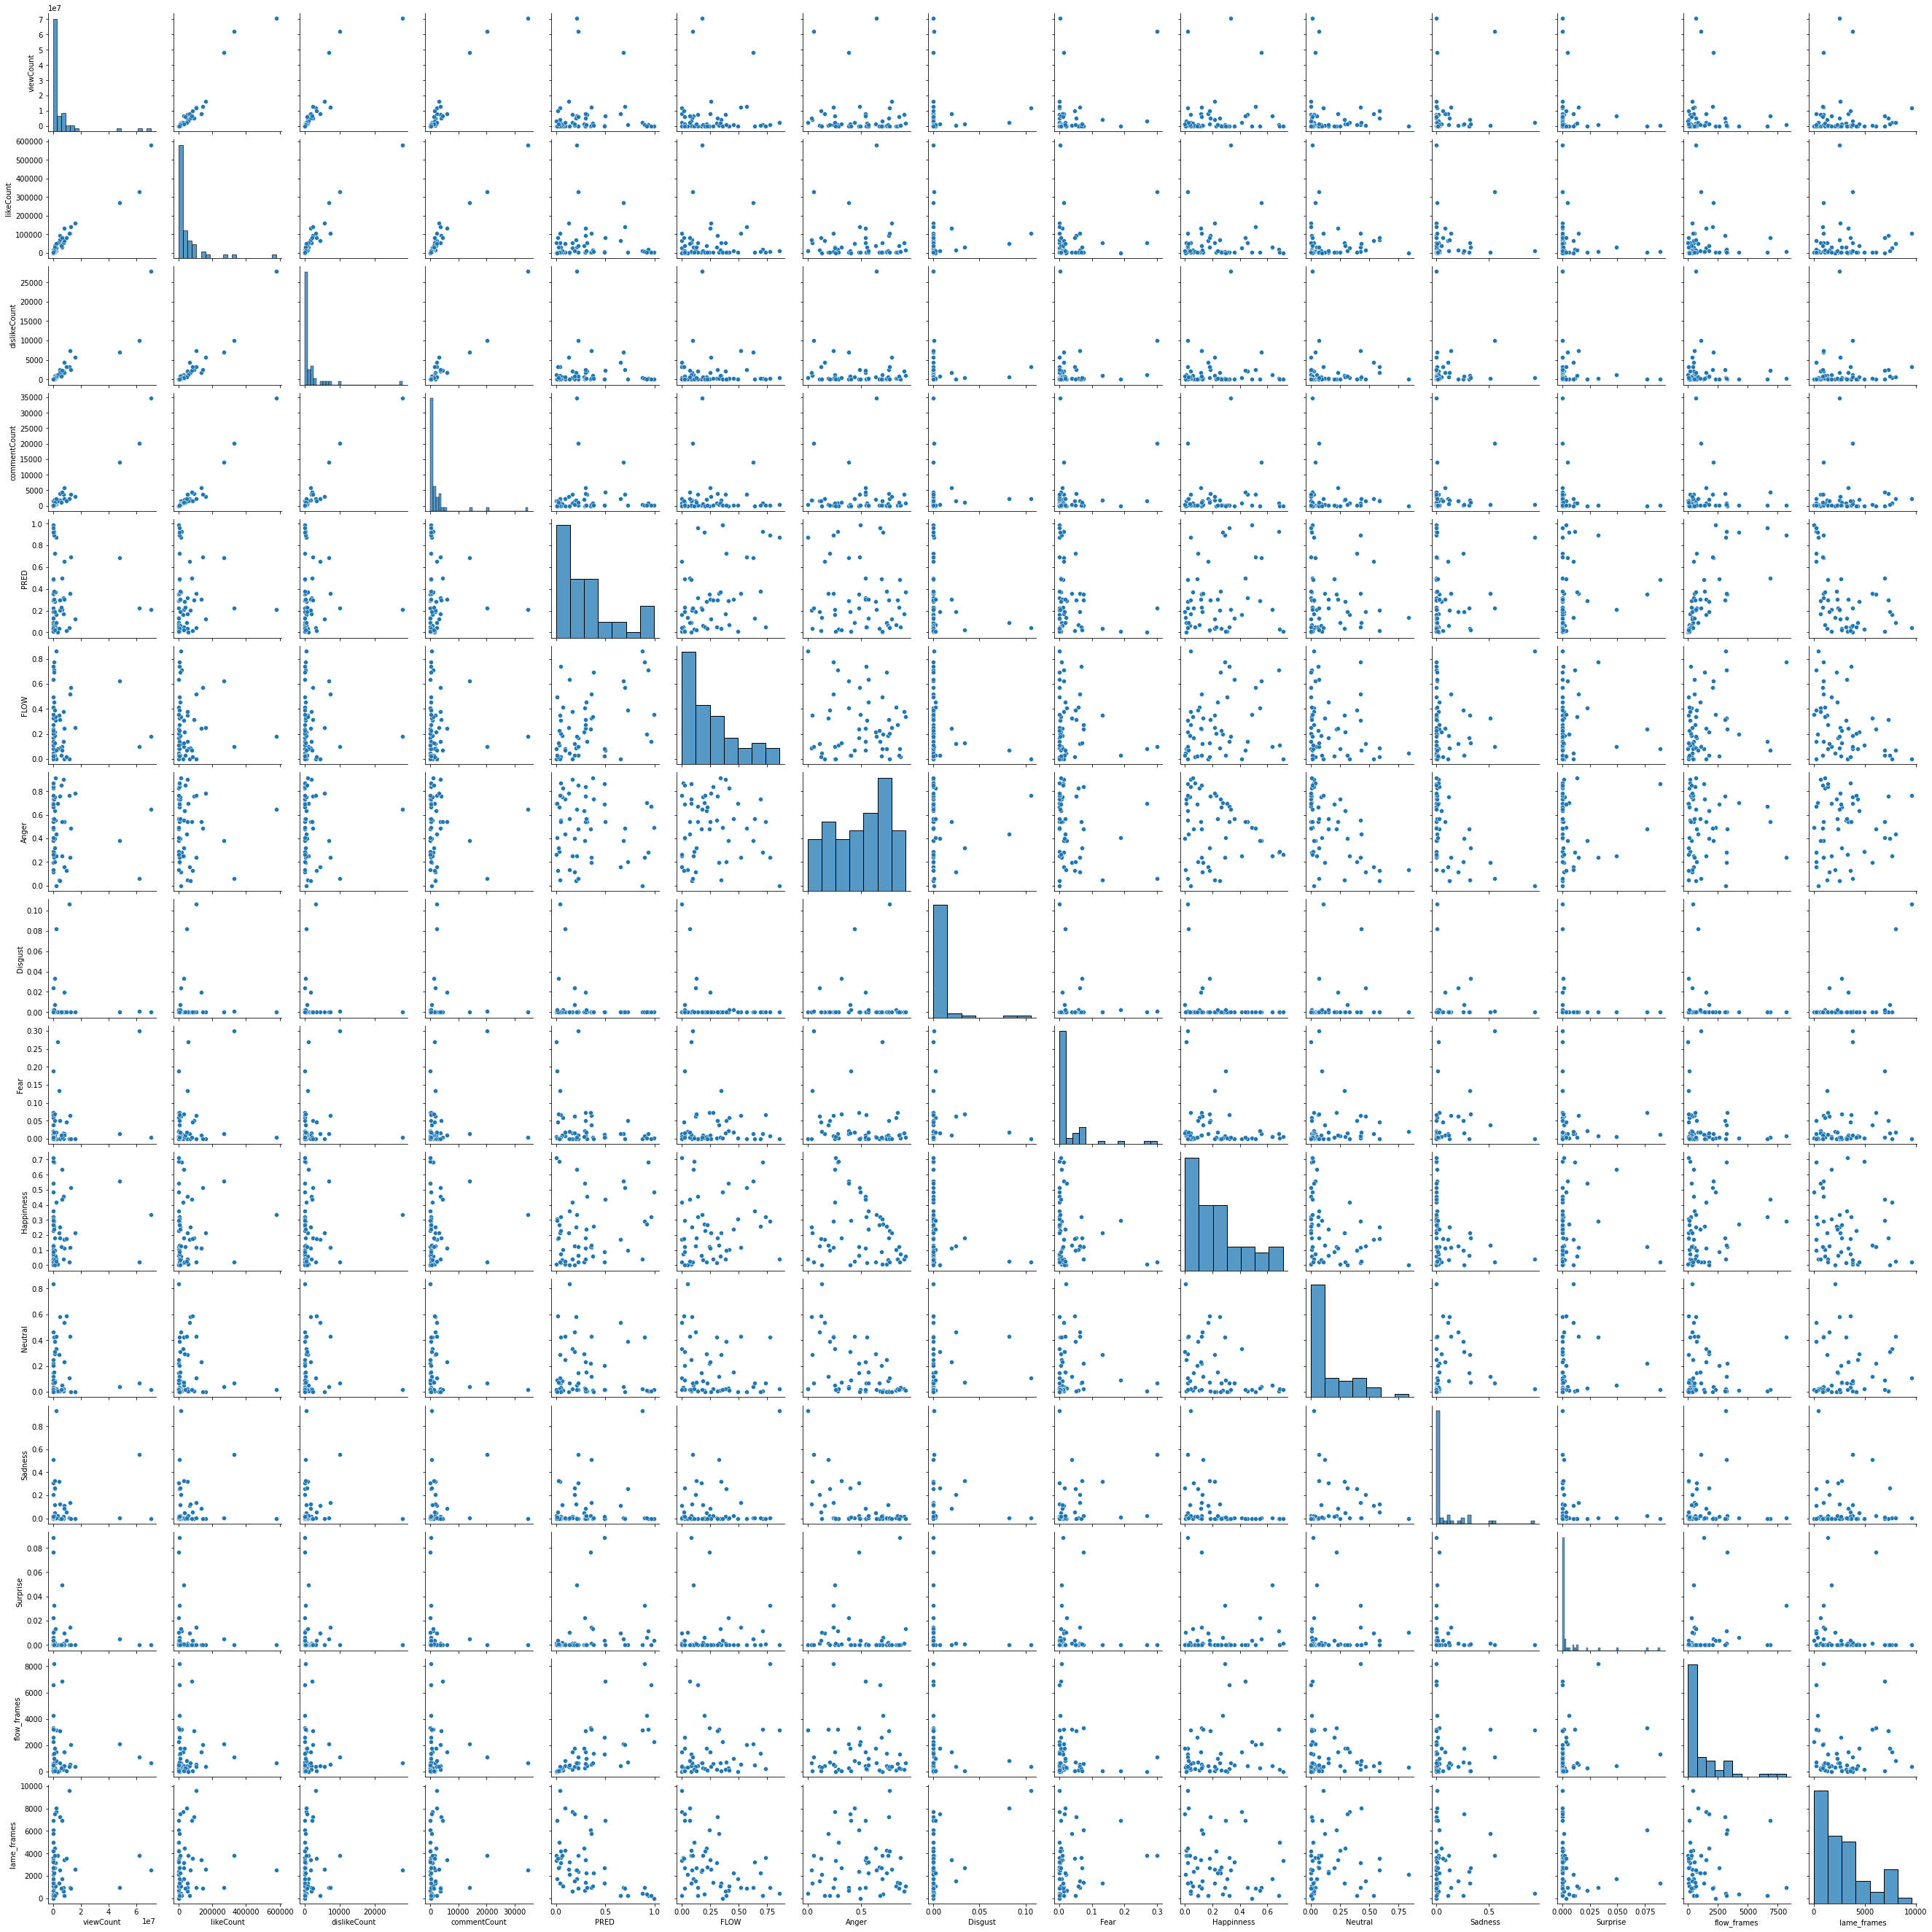

In [15]:
sns.pairplot(videos.drop(columns=['like_view_ratio', 'dislike_like_ratio', 'dislike_view_ratio','Frames', 'Zeit', 'Frames_CV', 'FRAME']))

Flow/Emotion and Ratios

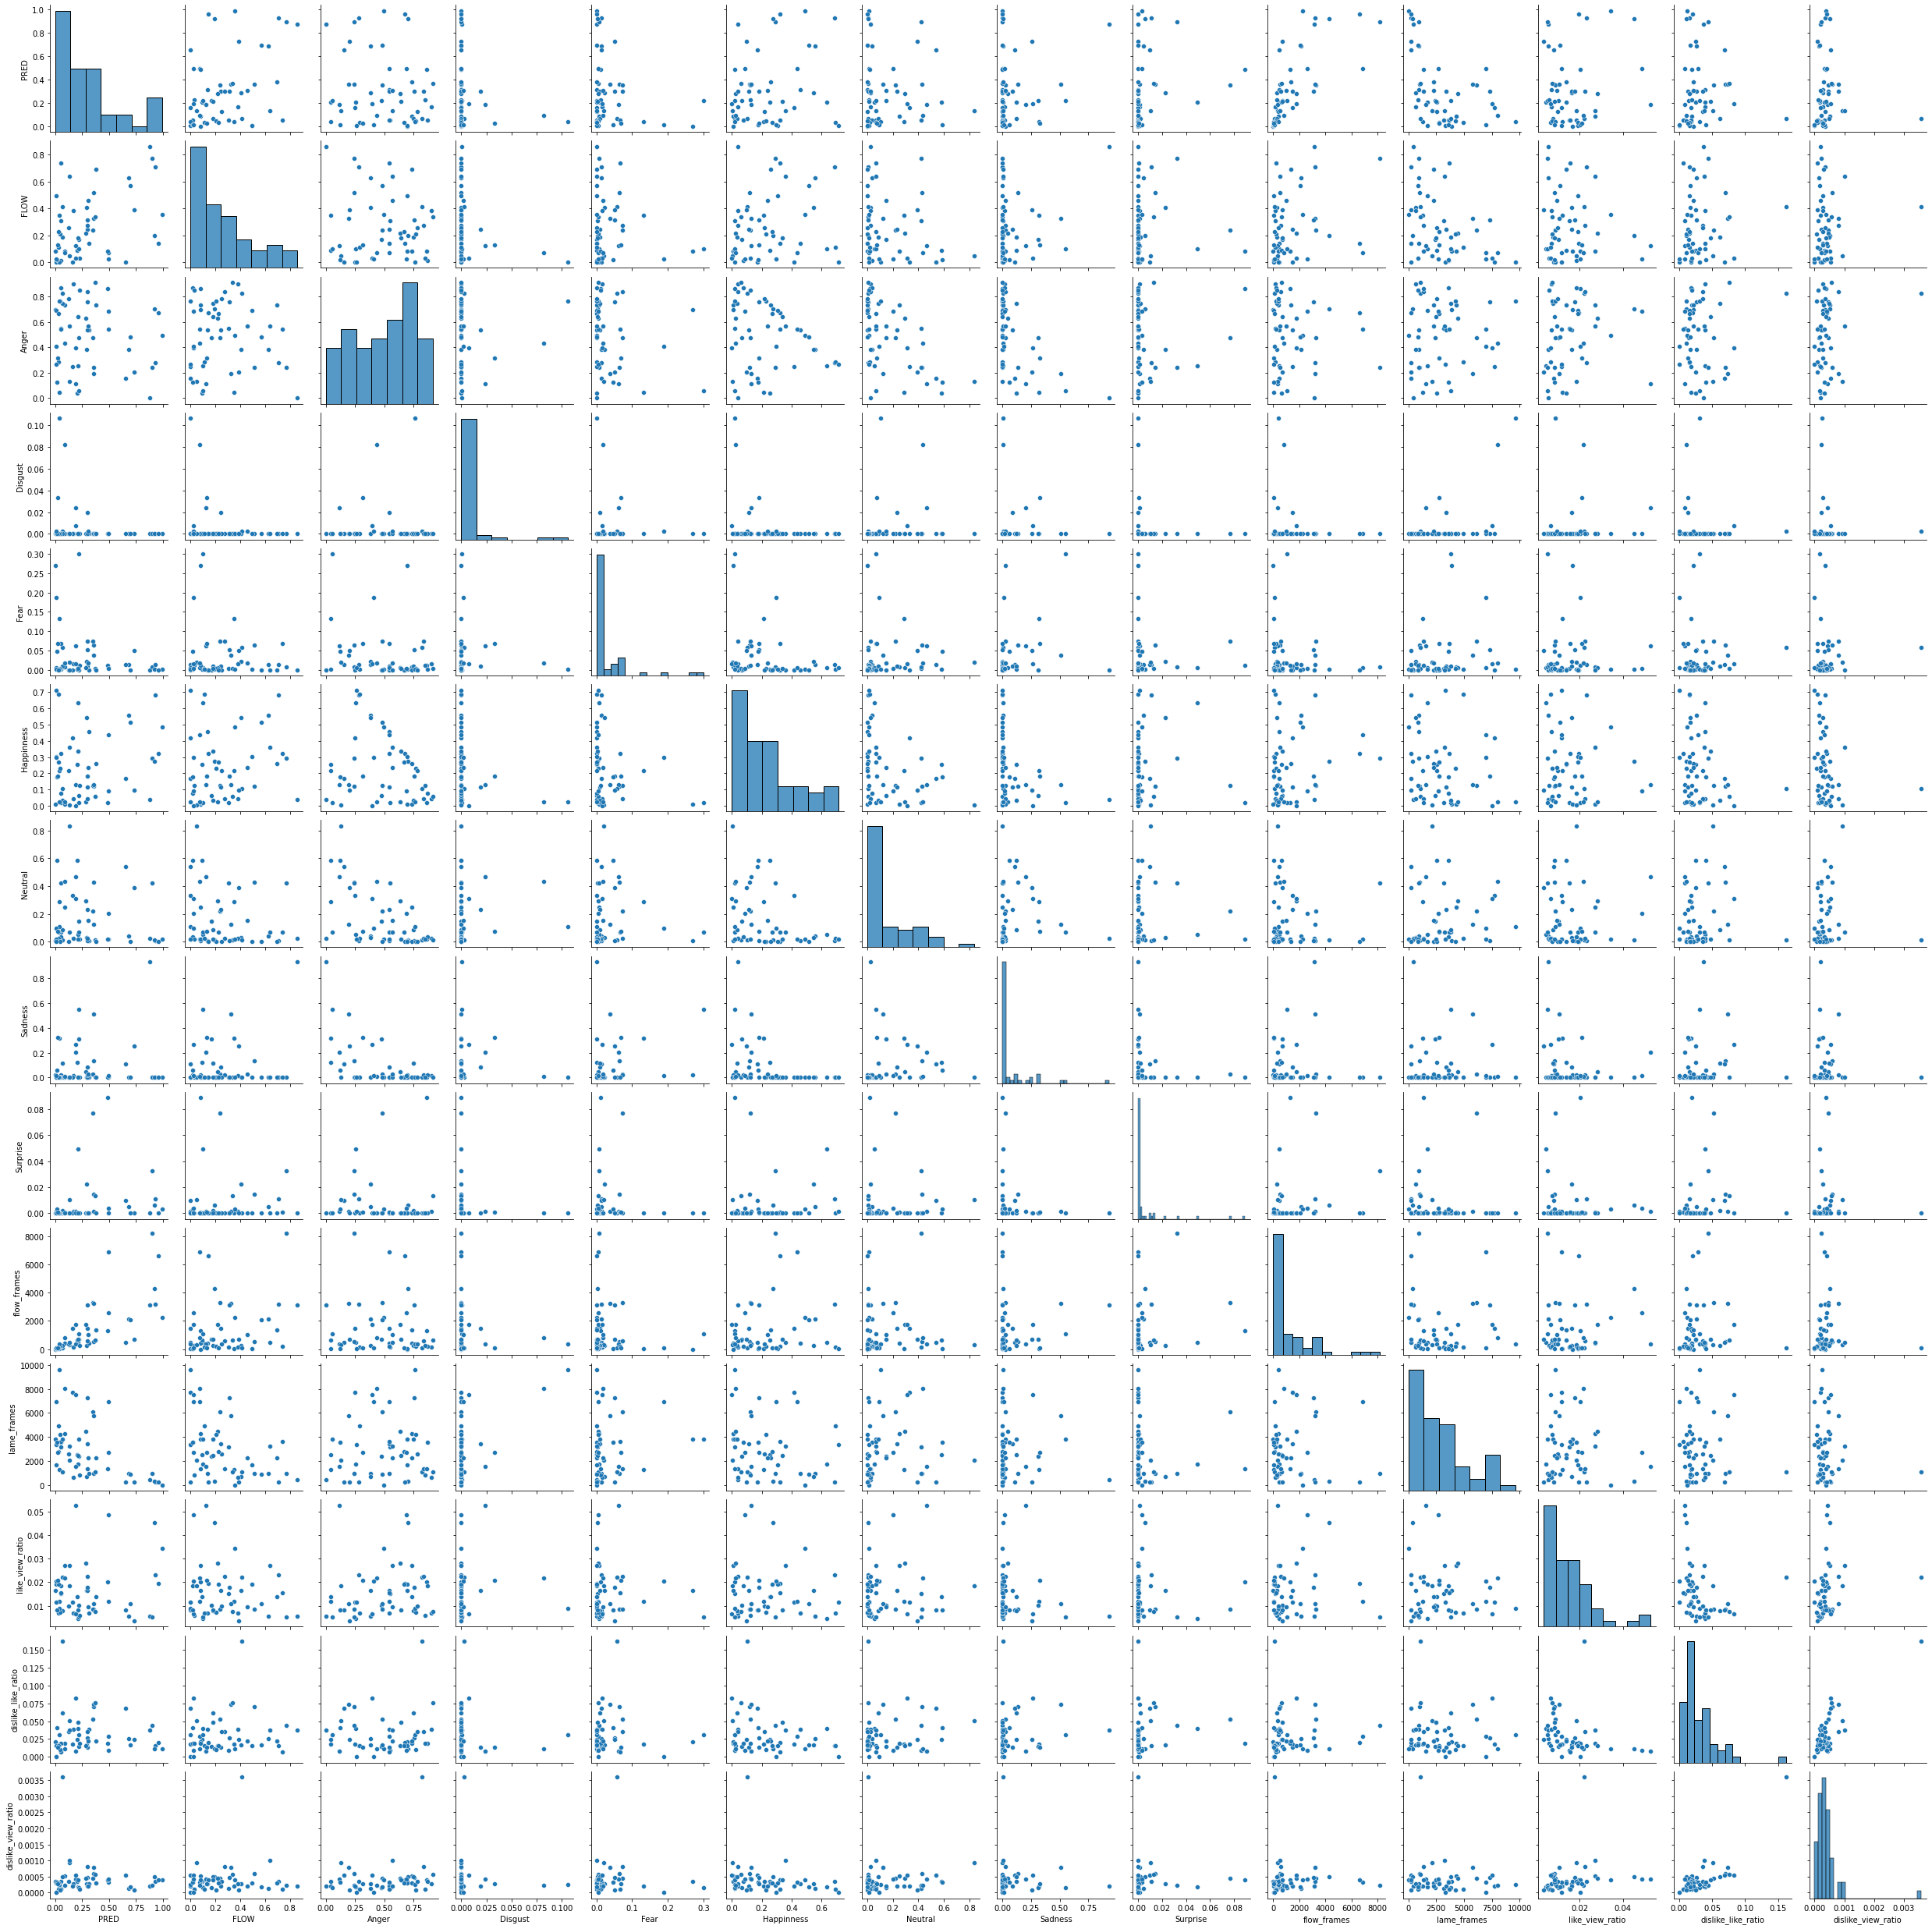

In [16]:
sns.pairplot(videos.drop(columns=['viewCount', 'likeCount', 'dislikeCount', 'commentCount', 'Frames', 'Zeit', 'Frames_CV', 'FRAME',]))

Flow/Emotion and Video Props

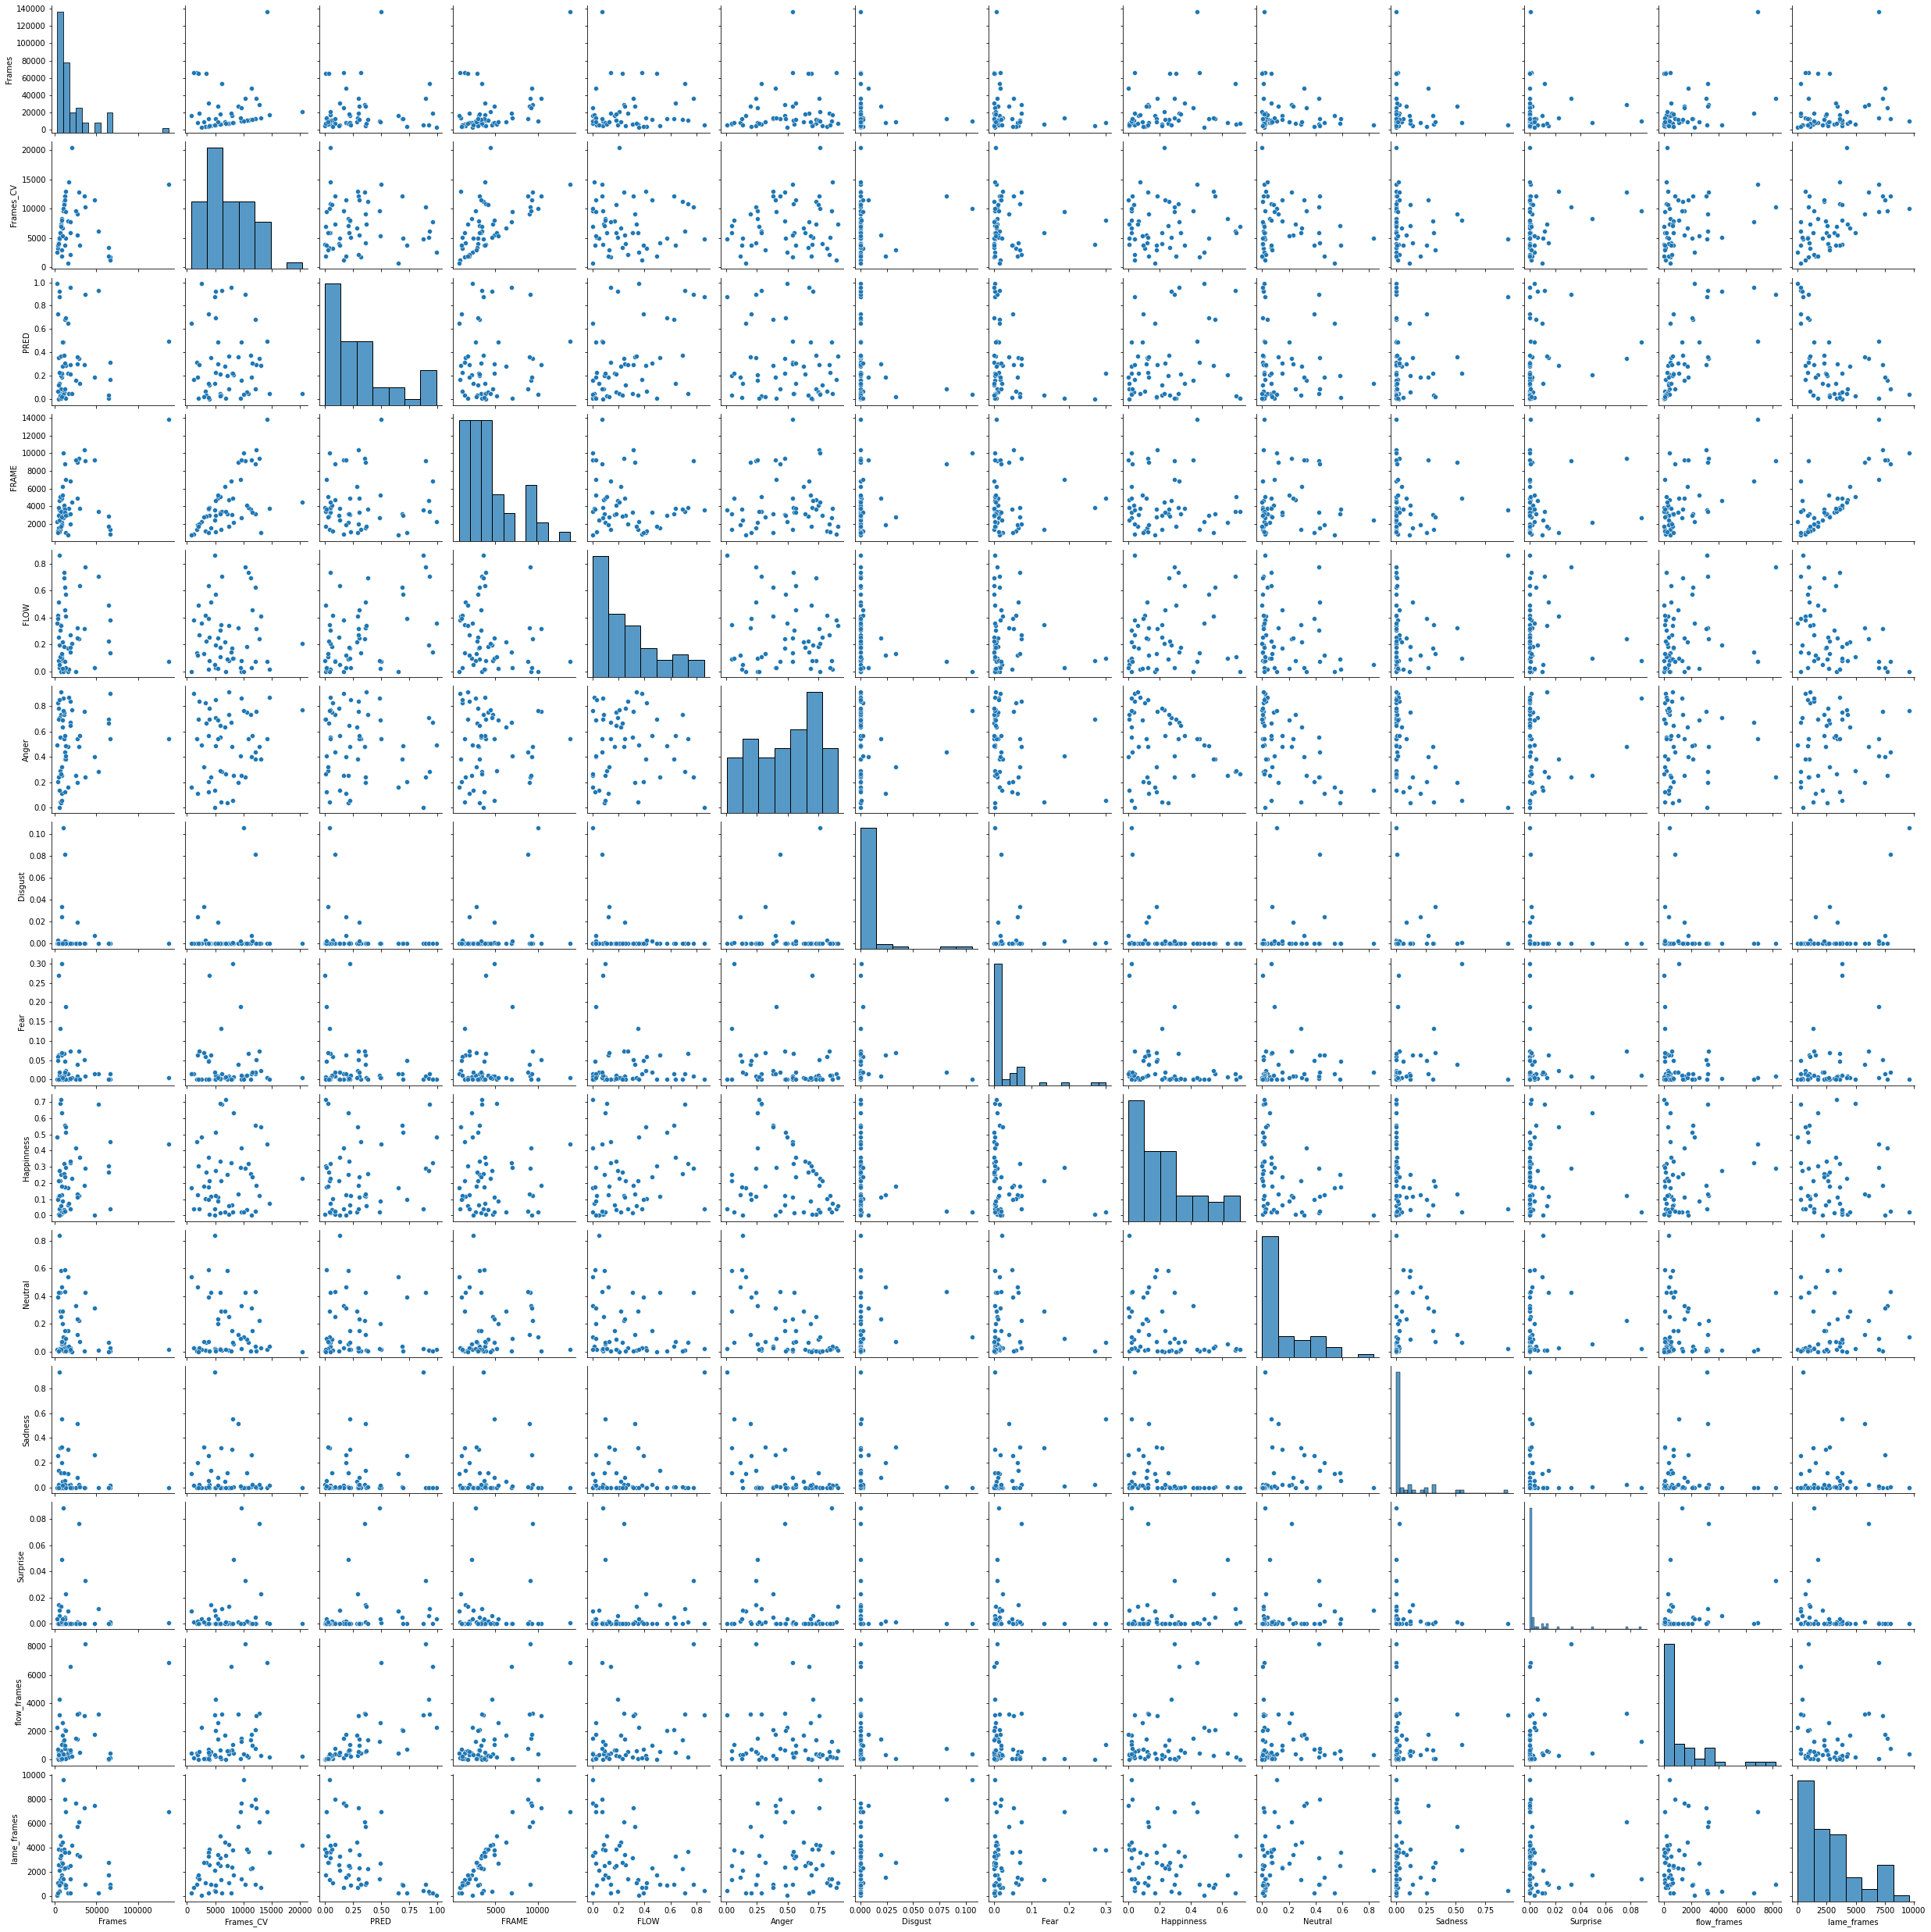

In [17]:
sns.pairplot(videos.drop(columns=['viewCount', 'likeCount', 'dislikeCount', 'commentCount', 'like_view_ratio', 'dislike_like_ratio', 'dislike_view_ratio']))

Video Props and Stats

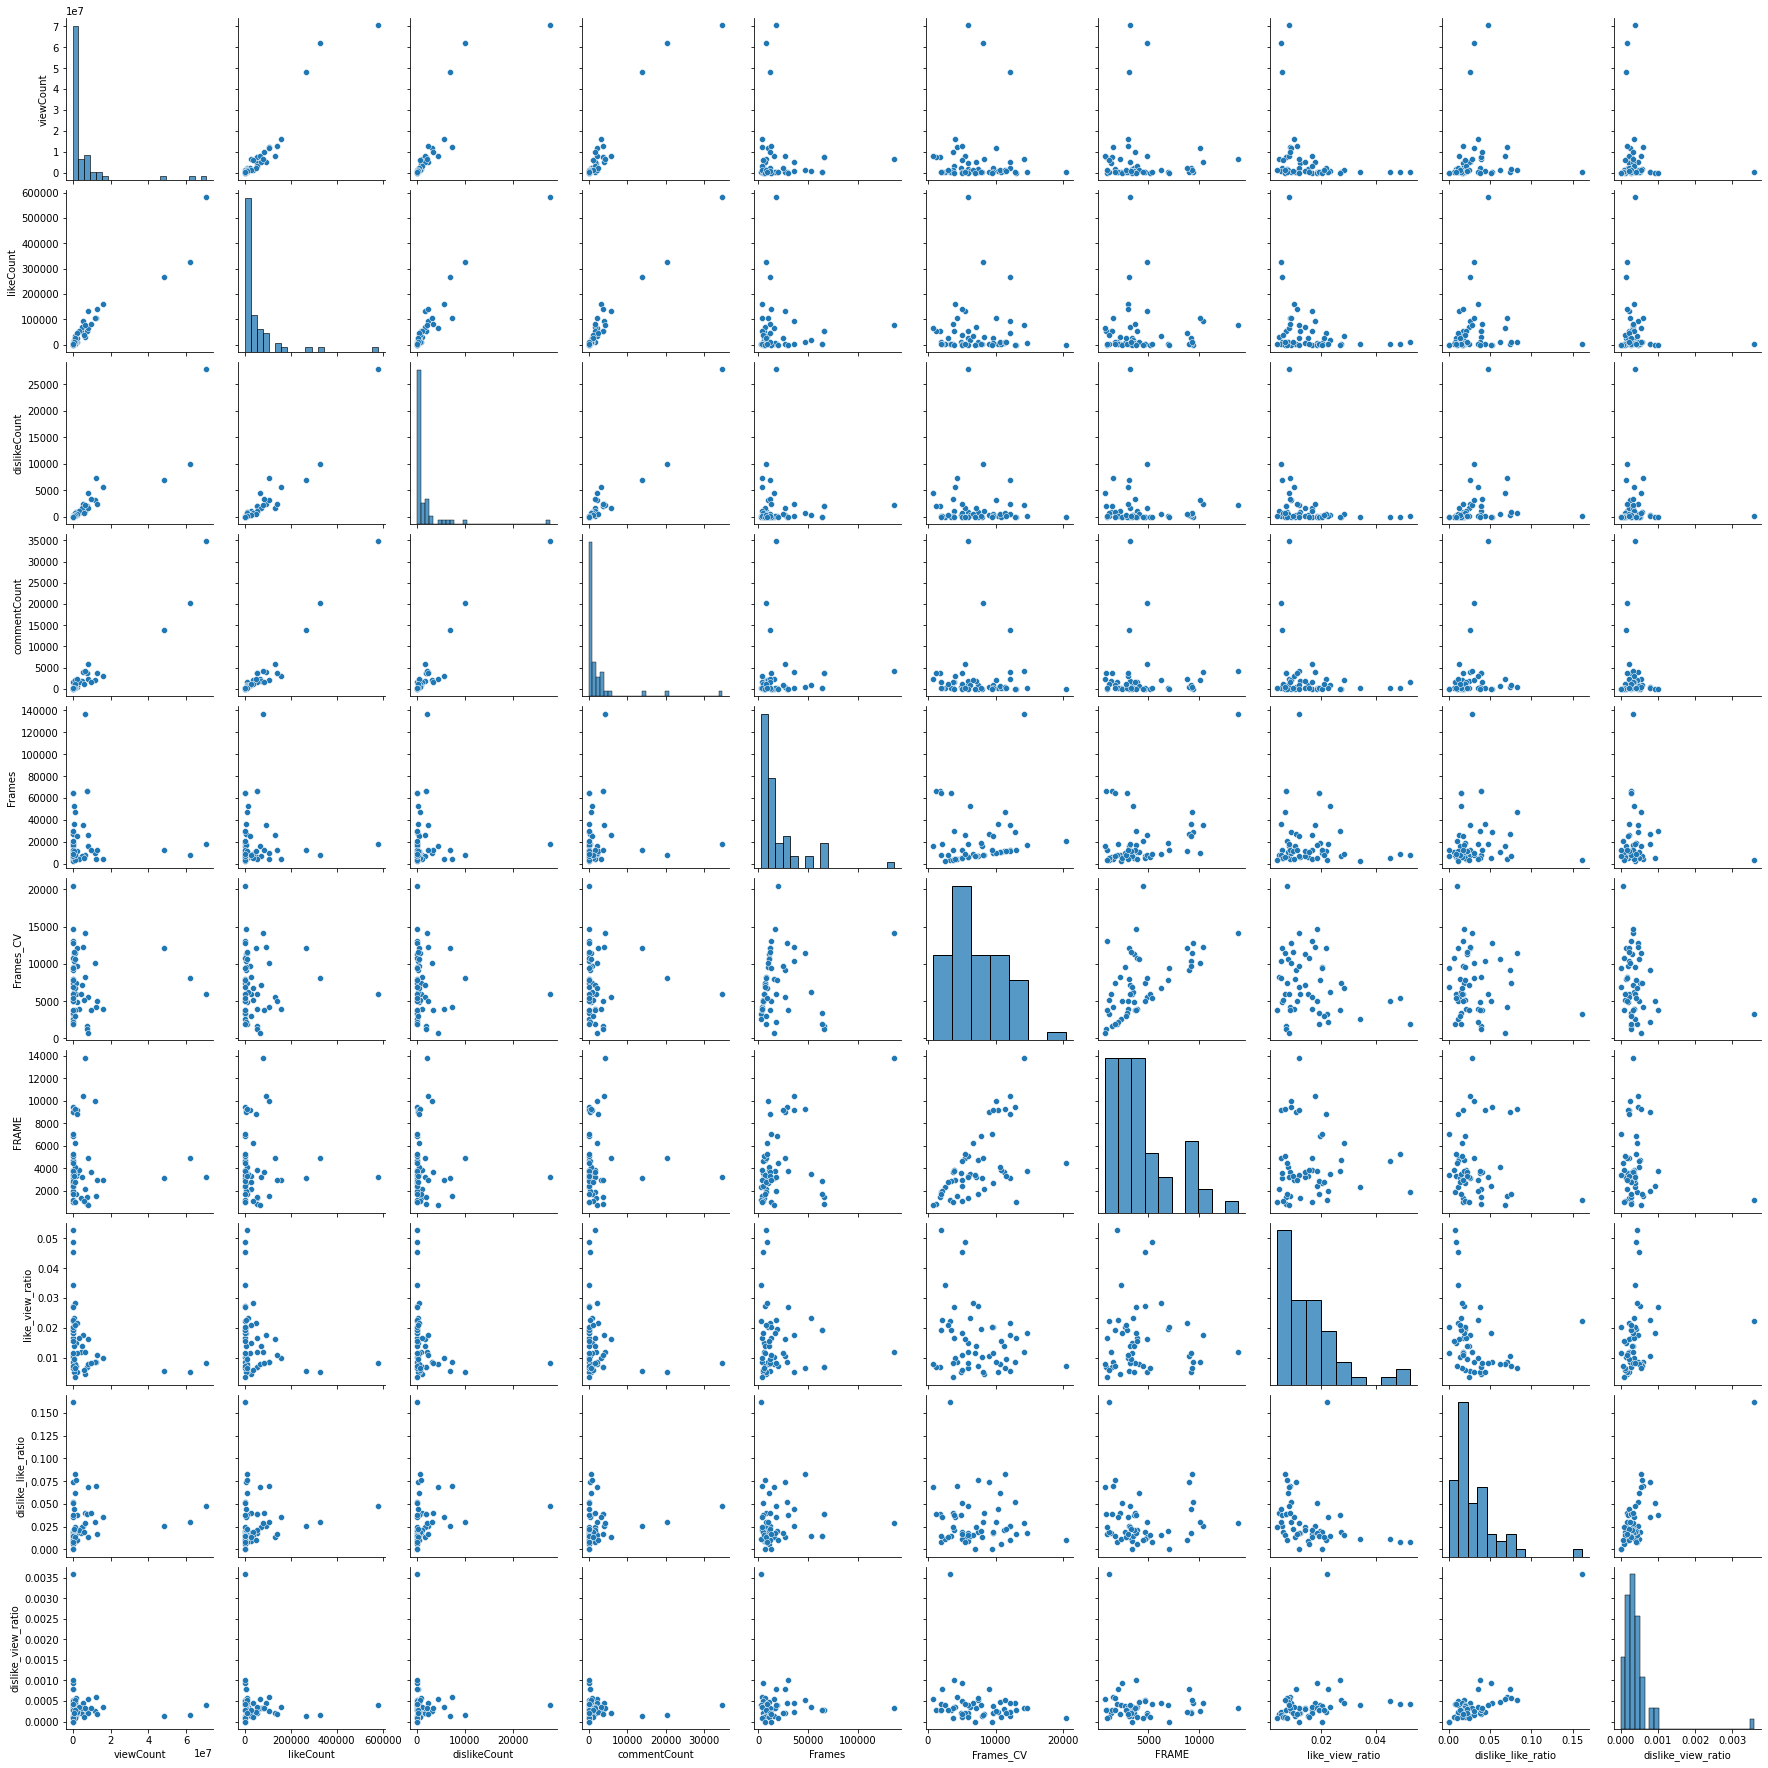

In [18]:
sns.pairplot(videos.drop(columns=['PRED',  'FLOW', 'Anger', 'Disgust', 'Fear', 'Happinness', 'Neutral', 'Sadness', 'Surprise', 'flow_frames','lame_frames']))